In [1]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.preprocessing import OneHotEncoder
from neural_network_wrapper import NeuralNetworkWrapper
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
import optimizers

import json

In [2]:
data_simple_train_100 = pd.read_csv("./projekt1/classification/data.simple.train.100.csv")
data_simple_train_500 = pd.read_csv("./projekt1/classification/data.simple.train.500.csv")
data_simple_train_1000 = pd.read_csv("./projekt1/classification/data.simple.train.1000.csv")
data_simple_train_10000 = pd.read_csv("./projekt1/classification/data.simple.train.10000.csv")

data_simple_test_100 = pd.read_csv("./projekt1/classification/data.simple.test.100.csv")
data_simple_test_500 = pd.read_csv("./projekt1/classification/data.simple.test.500.csv")
data_simple_test_1000 = pd.read_csv("./projekt1/classification/data.simple.test.1000.csv")
data_simple_test_10000 = pd.read_csv("./projekt1/classification/data.simple.test.10000.csv")

In [3]:
def prepare_data_simple(train_data, test_data):
    
    X_train = np.array(train_data.loc[:, ['x', 'y']])
    y_train = train_data.cls
    y_train -= 1
    #one hot encoding
    y_ohc = np.zeros((y_train.size, int(np.max(y_train))+1))
    y_ohc[np.arange(y_train.size),y_train.astype(np.int)] = 1
    y_train = y_ohc
    
    X_test = np.array(test_data.loc[:, ['x', 'y']])
    y_test = test_data.cls
    y_test -= 1
    #one hot encoding
    y_ohc = np.zeros((y_test.size, int(np.max(y_test))+1))
    y_ohc[np.arange(y_test.size),y_test.astype(np.int)] = 1
    y_test = y_ohc
    
    
    # Are we supposed to use StandardScaler?
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    return {"X_train": X_train,
           "X_test": X_test,
           "y_train": y_train,
           "y_test": y_test}

In [4]:
data = [{"dataset name": "Data simple 100 obs",
        "data": prepare_data_simple(data_simple_train_100, data_simple_test_100)},
       {"dataset name": "Data simple 500 obs",
        "data": prepare_data_simple(data_simple_train_500, data_simple_test_500)},
       {"dataset name": "Data simple 1000 obs",
        "data": prepare_data_simple(data_simple_train_1000, data_simple_test_1000)},
       {"dataset name": "Data simple 10000 obs",
        "data": prepare_data_simple(data_simple_train_10000, data_simple_test_10000)}]

In [5]:
def perform_experiment(dataset,
                       d,
                       exp_objective,
                       exp_values,
                       num_reps):
    """
    """
    X_train = dataset['X_train']
    y_train = dataset['y_train']
    X_test = dataset['X_test']
    y_test = dataset['y_test']

    d = d.copy()
    
    for k in exp_values.keys():
        d[k] = {}
        d[k]['test_accuracy'] = []
    
    for i in range(num_reps):
        #print(f"Experiment {i+1}/{num_reps}")
    
        # reproducibility issues
        random.seed(d['seed'] + i)
        np.random.seed(d['seed'] + i)
    
        # testing learning rate
        for k, v in exp_values.items():
            if exp_objective == 'lr':

                NN = NeuralNetworkWrapper(d['input_dim'],
                                      d['neuron_numbers'],
                                      ['relu'] * (len(d['neuron_numbers']) - 1) + d['output_activation'],
                                      d['loss_function'],
                                      v,
                                      optimizers.Optimizer(),
                                      d['batch_size'])
            
            elif exp_objective == 'activation_function':
                
                NN = NeuralNetworkWrapper(d['input_dim'],
                                          d['neuron_numbers'],
                                          v * (len(d['neuron_numbers']) - 1) + d['output_activation'],
                                          d['loss_function'],
                                          d['learning_rate'],
                                          optimizers.Optimizer(),
                                          d['batch_size'])
            
            elif exp_objective == 'inertia':
                
                NN = NeuralNetworkWrapper(d['input_dim'],
                                          d['neuron_numbers'],
                                          ['relu'] * (len(d['neuron_numbers']) - 1) + d['output_activation'],
                                          d['loss_function'],
                                          d['learning_rate'],
                                          optimizers.GDwithMomentum(v),
                                          d['batch_size'])
            
            elif exp_objective == 'batch_size':
                
                NN = NeuralNetworkWrapper(d['input_dim'],
                                          d['neuron_numbers'],
                                          ['relu'] * (len(d['neuron_numbers']) - 1) + d['output_activation'],
                                          d['loss_function'],
                                          d['learning_rate'],
                                          optimizers.Optimizer(),
                                          v)
            
                
            NN.train(X_train,
                     y_train,
                     d['num_epochs'],
                     validation_split = 0,
                     test_accuracy=(X_test, y_test),
                     verbosity=False)
                
            d[k]['test_accuracy'].append(NN.test_accuracy)

    for k in exp_values.keys():
        # aggregating results
        d[k]['test_accuracy_mean'] = np.mean(np.array(d[k]['test_accuracy']).T, axis=1)
        d[k]['test_accuracy_std'] = np.std(np.array(d[k]['test_accuracy']).T, axis=1)

        d[k] = {"Accuracy": d[k]['test_accuracy_mean'],
               "Accuracy std": d[k]['test_accuracy_std'],
               "Best Accuracy": np.max(d[k]['test_accuracy_mean']),
               "Best Accuracy std": d[k]['test_accuracy_std'][np.argmax(d[k]['test_accuracy_mean'])]}

    return {k: d[k] for k in exp_values.keys()}


In [6]:
def experiments_pipeline(data,
                         experiment_dict,
                         experiments,
                         num_reps=1,
                         save_to_file=False):
    """
    """
    d = experiment_dict.copy()
    output = {'lr':{},
             'activation_function':{},
             'inertia':{},
             'batch_size':{}}
    # Experiments for each dataset
    for dataset in data:
        print("------ Dataset name: {}".format(dataset['dataset name']))
        output['lr'][dataset['dataset name']] = perform_experiment(dataset['data'],
                                                     experiment_dict,
                                                     'lr',
                                                     experiments['lr'],
                                                     num_reps)
        output['activation_function'][dataset['dataset name']] = perform_experiment(dataset['data'],
                                                        experiment_dict,
                                                        'activation_function',
                                                        experiments['activation_function'],
                                                        num_reps)
        
        output['inertia'][dataset['dataset name']] = perform_experiment(dataset['data'],
                                                        experiment_dict,
                                                        'inertia',
                                                        experiments['inertia'],
                                                        num_reps)
        
        output['batch_size'][dataset['dataset name']] = perform_experiment(dataset['data'],
                                                        experiment_dict,
                                                        'batch_size',
                                                        experiments['batch_size'],
                                                        num_reps)
        
        
        
    return output

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style("white")
#sns.despine(left=True, bottom=True)

#plt.style.use('seaborn-deep')
plt.style.use('seaborn-white')

# Available matplotlib styles:
# ['seaborn-colorblind', 'fast', 'seaborn-deep', 'fivethirtyeight', 'seaborn',
#  'Solarize_Light2', 'seaborn-talk', 'seaborn-darkgrid', 'ggplot', 'seaborn-bright',
#  'seaborn-paper', 'seaborn-pastel', 'bmh', 'seaborn-dark', 'seaborn-notebook',
#  'tableau-colorblind10', 'seaborn-white', '_classic_test', 'seaborn-ticks',
#  'seaborn-poster', 'seaborn-muted', 'dark_background', 'grayscale',
#  'seaborn-dark-palette', 'seaborn-whitegrid', 'classic']

def visualize_experiment(d, title="", figsize=(21, 12)):
    
    fig, a = plt.subplots(2, 2)
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])
    dataset_names = list(d.keys())
    
    fig.suptitle(title, fontsize=30)
    
    counter = 0
    for i in range(2):
        for j in range(2):
            
            subplot_dict = d[dataset_names[counter]]
            
            a[i][j].title.set_text(f'Accuracy in {dataset_names[counter]}')
            a[i][j].set_ylim((0, 1))
            a[i][j].set_xticks(range(1, 1 + len(subplot_dict[list(subplot_dict.keys())[0]]['Accuracy'])))
            
            a[i][j].set_xlabel('Epoch')
            a[i][j].set_ylabel('Accuracy')
            
            for k, v in subplot_dict.items():
                a[i][j].errorbar([it+1 for it in range(len(v['Accuracy']))],
                                 v['Accuracy'],
                                 yerr=v['Accuracy std'],
                                 linestyle='--',
                                 marker='o',
                                 label=k)

                
                
                a[i][j].legend(loc="lower right")
            
            counter += 1
    
    plt.show()
    
    # Experiment report
    dataset_names = []
    x = {}
    for dataset_name, exp_results in d.items():
        dataset_names.append(dataset_name)

        for k, v in exp_results.items():
            try:
                x[k].append("{:.2f} +- {:.2f}".format(v['Best Accuracy'], v['Best Accuracy std']))
            except:
                x[k] = ["{:.2f} +- {:.2f}".format(v['Best Accuracy'], v['Best Accuracy std'])]

    y = pd.DataFrame(x)
    y.index = dataset_names
    y.transpose()
    
    return y

In [15]:
# CETERIS PARIBUS NETWORK ARCHITECTURE 
experiment_dict = {
    "input_dim" : 2,
    "neuron_numbers" : [4, 4, 2], # number of neurons in consecutive layers
    "activation_functions" : ['relu', 'relu'],
    "loss_function" : 'logistic_loss',
    "batch_size" : 64,
    "num_epochs" : 10,
    "seed" : 42,
    "output_activation" : ['sigmoid'],
    "learning_rate" : 0.001
}

experiments = {'lr':
                   {'lr=0.0001' : 0.0001,
                    'lr=0.001' : 0.001,
                    'lr=0.01' : 0.01,
                    'lr=0.1' : 0.1},
               'activation_function': 
                   {'relu' : ['relu'],
                    'leaky relu' : ['leaky_relu']},
               'inertia' : 
                   {'beta=0' : 0,
                    'beta=0.5' : 0.5,
                    'beta=0.9' : 0.9},
               'batch_size' : 
                   {'bs=4' : 4,
                    'bs=16' : 16,
                    'bs=32' : 32,
                    'bs=64' : 64}
              }

In [16]:
ans = experiments_pipeline(data, experiment_dict, experiments, num_reps=20)

------ Dataset name: Data simple 100 obs
Final loss: 1.691
Final loss: 2.040
Final loss: 1.524
Final loss: 0.679
Final loss: 3.377
Final loss: 1.385
Final loss: 1.402
Final loss: 1.229
Final loss: 2.989
Final loss: 1.437
Final loss: 2.037
Final loss: 0.951
Final loss: 1.635
Final loss: 1.741
Final loss: 1.597
Final loss: 0.507
Final loss: 2.454
Final loss: 2.223
Final loss: 1.471
Final loss: 0.307
Final loss: 1.586
Final loss: 1.848
Final loss: 1.359
Final loss: 0.312
Final loss: 4.745
Final loss: 1.541
Final loss: 1.314
Final loss: 0.977
Final loss: 2.808
Final loss: 3.427
Final loss: 2.443
Final loss: 0.402
Final loss: 2.139
Final loss: 2.652
Final loss: 1.178
Final loss: 1.383
Final loss: 1.550
Final loss: 1.559
Final loss: 2.277
Final loss: 1.037
Final loss: 2.186
Final loss: 2.212
Final loss: 1.419
Final loss: 0.724
Final loss: 1.145
Final loss: 1.602
Final loss: 1.900
Final loss: 1.367
Final loss: 1.321
Final loss: 1.160
Final loss: 1.536
Final loss: 0.578
Final loss: 1.706
Final

KeyboardInterrupt: 

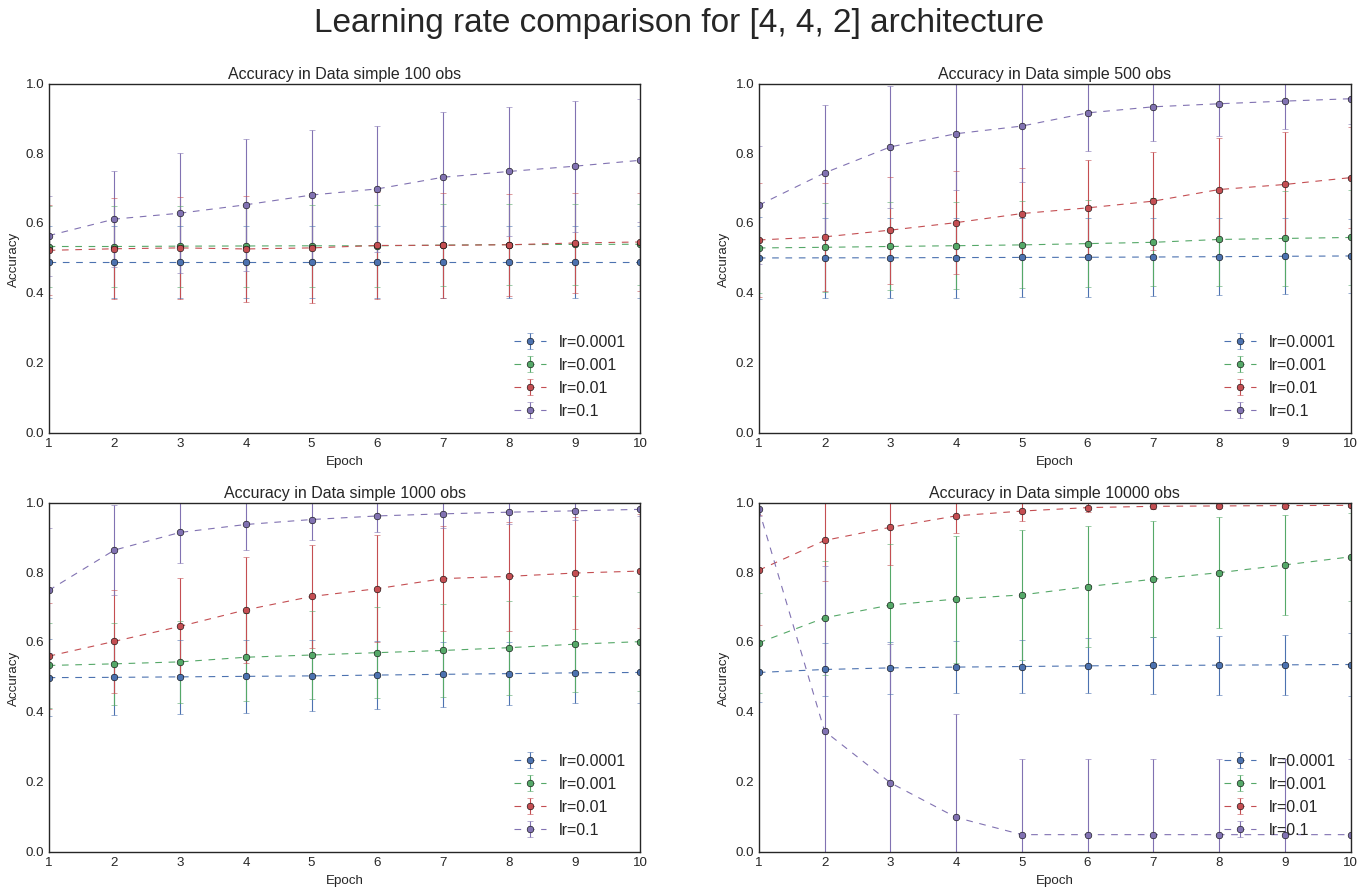

,lr=0.0001,lr=0.001,lr=0.01,lr=0.1
Data simple 100 obs,0.49 +- 0.10,0.54 +- 0.12,0.55 +- 0.14,0.78 +- 0.18
Data simple 500 obs,0.51 +- 0.11,0.56 +- 0.14,0.73 +- 0.15,0.96 +- 0.07
Data simple 1000 obs,0.51 +- 0.09,0.60 +- 0.14,0.80 +- 0.16,0.98 +- 0.02
Data simple 10000 obs,0.54 +- 0.09,0.85 +- 0.13,0.99 +- 0.00,0.98 +- 0.02


In [35]:
visualize_experiment(ans['lr'],
                     title='Learning rate comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])))

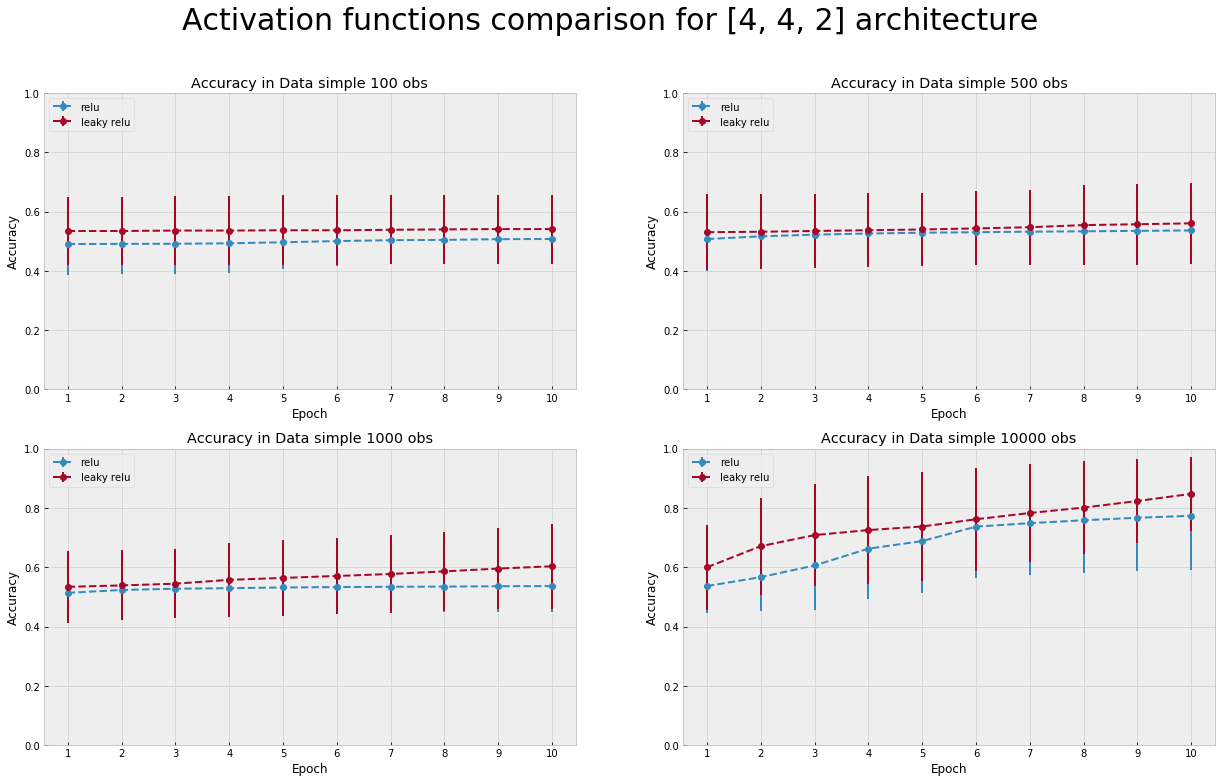

,relu,leaky relu
Data simple 100 obs,0.51 +- 0.08,0.54 +- 0.12
Data simple 500 obs,0.54 +- 0.08,0.56 +- 0.14
Data simple 1000 obs,0.54 +- 0.09,0.60 +- 0.14
Data simple 10000 obs,0.77 +- 0.18,0.85 +- 0.13


In [11]:
visualize_experiment(ans['activation_function'],
                     title='Activation functions comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])))

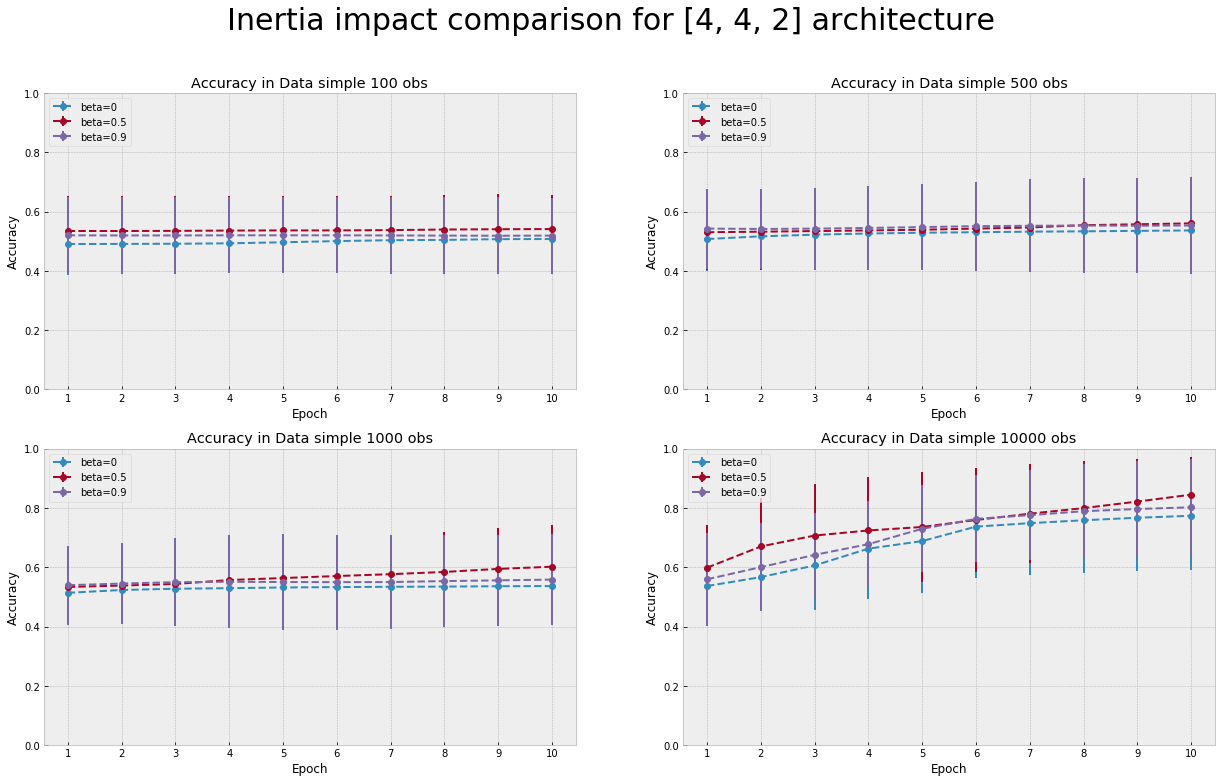

,beta=0,beta=0.5,beta=0.9
Data simple 100 obs,0.51 +- 0.08,0.54 +- 0.12,0.52 +- 0.13
Data simple 500 obs,0.54 +- 0.08,0.56 +- 0.14,0.55 +- 0.16
Data simple 1000 obs,0.54 +- 0.09,0.60 +- 0.14,0.56 +- 0.15
Data simple 10000 obs,0.77 +- 0.18,0.85 +- 0.13,0.80 +- 0.16


In [12]:
visualize_experiment(ans['inertia'],
                     title='Inertia impact comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])))

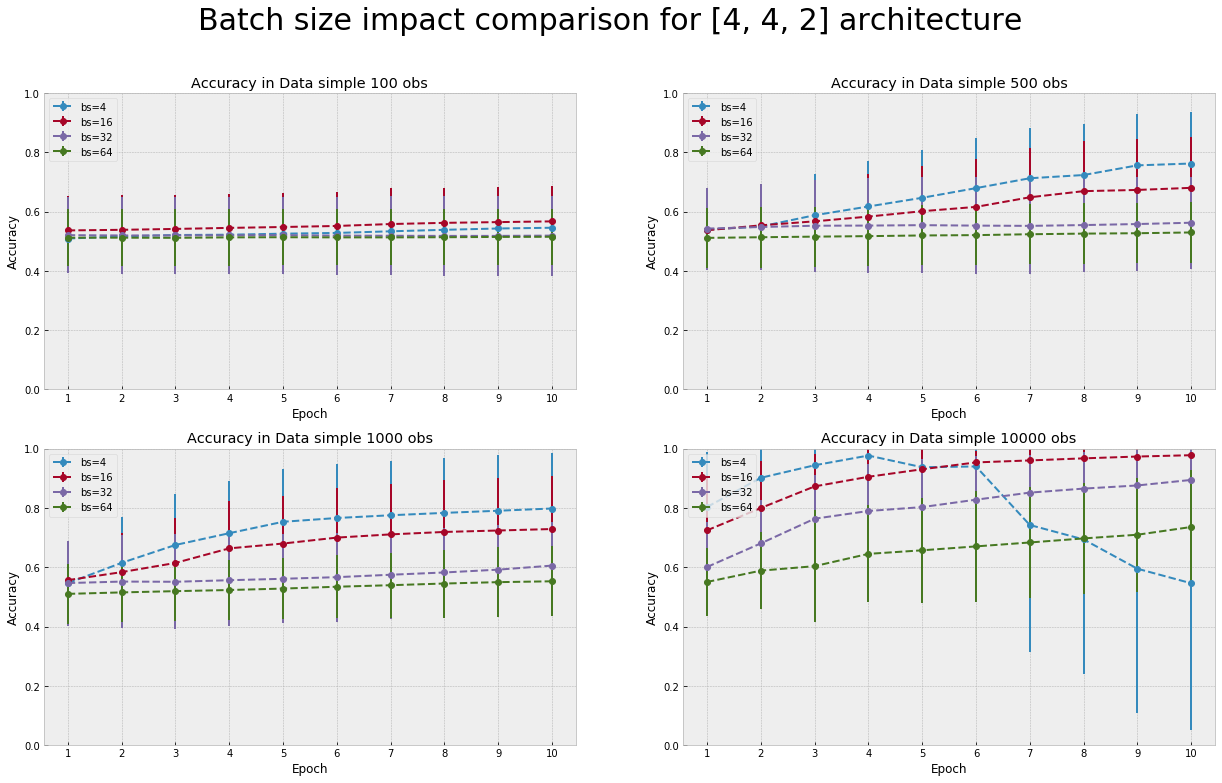

,bs=4,bs=16,bs=32,bs=64
Data simple 100 obs,0.55 +- 0.10,0.57 +- 0.12,0.52 +- 0.13,0.51 +- 0.09
Data simple 500 obs,0.76 +- 0.18,0.68 +- 0.17,0.56 +- 0.16,0.53 +- 0.10
Data simple 1000 obs,0.80 +- 0.19,0.73 +- 0.18,0.61 +- 0.15,0.55 +- 0.12
Data simple 10000 obs,0.98 +- 0.03,0.98 +- 0.02,0.89 +- 0.12,0.74 +- 0.19


In [13]:
visualize_experiment(ans['batch_size'],
                     title='Batch size impact comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])))